#### Instructions
###### Follow the instructions given in comments prefixed with ## and write your code below that.
###### Also fill the partial code in given blanks. 
###### Don't make any changes to the rest part of the codes

### Answer the questions given at the end of this notebook within your report.


### You would need to submit your GitHub repository link. Refer to the Section 6: Final Submission on the PDF document for the details.


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from dotenv import load_dotenv

load_dotenv()

True

In [20]:
import wandb
import os
wandb.login(key=os.getenv("WANDB_API_KEY"))
wandb.init(project='distance_classification_project')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


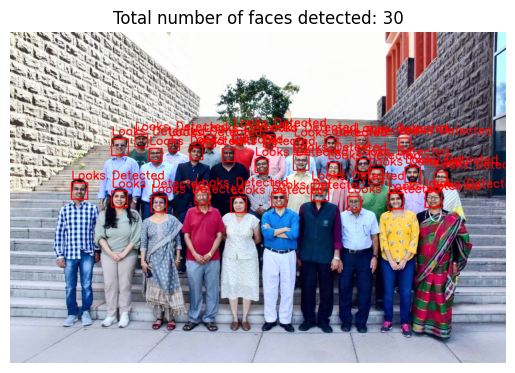

In [21]:
## Reading the image plaksha_Faculty.jpg

img = cv2.imread('Plaksha_Faculty.jpg')  
## Convert the image to grayscale

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
# Loading the required haar-cascade xml classifier file
face_cascade = cv2.CascadeClassifier("model\haarcascade_frontalface_default.xml")
  
# Applying the face detection method on the grayscale image. 
## Change the parameters for better detection of faces in your case.
faces_rect = face_cascade.detectMultiScale(gray_img, 1.05, 4, minSize=(25,25), maxSize=(50,50))
 
# Define the text and font parameters
text = "Looks Detected" ## The text you want to write
font = cv2.FONT_HERSHEY_SIMPLEX  ## Font type
font_scale = 1  ## Font scale factor
font_color = (0, 0, 255)  ## Text color in BGR format (here, it's red)
font_thickness = 2  ## Thickness of the text

  
# Iterating through rectangles of detected faces
for (x, y, w, h) in faces_rect:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    # Use cv2.putText to add the text to the image, Use text, font, font_scale, font_color, font_thickness here
    cv2.putText(img, text, (x, y-10), font, font_scale, font_color, font_thickness)

wandb.log({"Total number of face detected are": len(faces_rect)})
    
## Display the image and window title should be "Total number of face detected are #"  
cv2.imwrite("output/Plaksha_Faculty_detected.jpg", img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Total number of faces detected: {}".format(len(faces_rect)))
plt.axis('off')
plt.show()

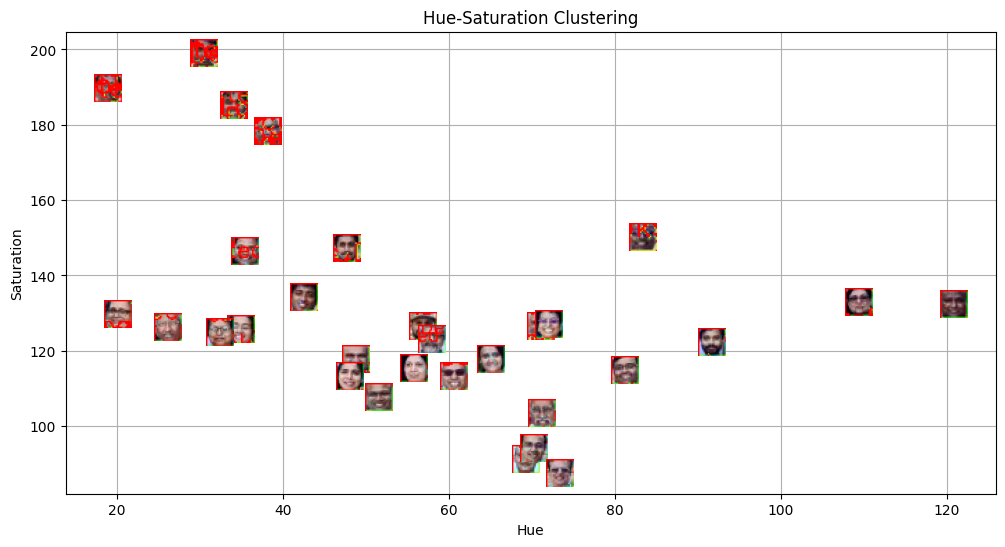

In [22]:

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
# Extract face region features (Hue and Saturation)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) ## call the img and convert it from BGR to HSV and store in img_hsv
hue_saturation = []
face_images = []  # To store detected face images

for (x, y, w, h) in faces_rect:
    face = img_hsv[y:y + h, x:x + w]
    hue = np.mean(face[:, :, 0])
    saturation = np.mean(face[:, :, 1])
    hue_saturation.append((hue, saturation))
    face_images.append(face)

hue_saturation = np.array(hue_saturation)

## Perform k-Means clustering on hue_saturation and store in kmeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(hue_saturation)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the clustered faces with custom markers
for i, (x,y,w,h ) in enumerate(faces_rect):
    im = OffsetImage(cv2.cvtColor(cv2.resize(face_images[i], (20, 20)), cv2.COLOR_HSV2RGB))
    ab = AnnotationBbox(im, (hue_saturation[i, 0], hue_saturation[i, 1]), frameon=False, pad=0)
    ax.add_artist(ab)
    plt.plot(hue_saturation[i, 0], hue_saturation[i, 1])
    

plt.xlabel('Hue')
plt.ylabel('Saturation')
plt.title('Hue-Saturation Clustering')
plt.grid(True)
plt.show()
wandb.log({"Hue-Saturation Clustering ": wandb.Image(fig)})

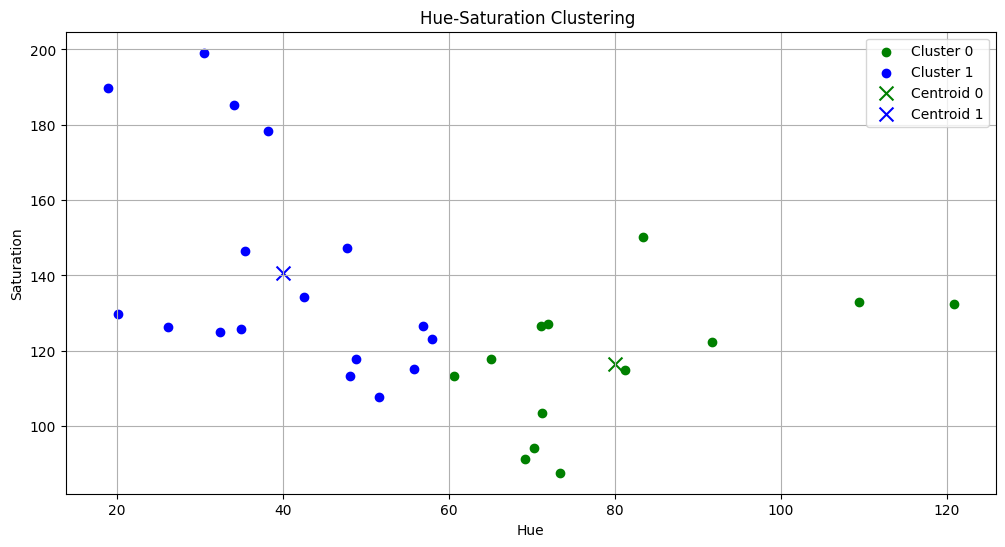

In [23]:
# Create an empty list to store legend labels
legend_labels = []

# Create lists to store points for each cluster
cluster_0_points = []
cluster_1_points = []

# Your code for scatter plot goes here
fig, ax = plt.subplots(figsize=(12, 6))
for i, (x, y, w, h) in enumerate(faces_rect):
    if kmeans.labels_[i] == 0:
        cluster_0_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))
    else:
        cluster_1_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))


cluster_0_points = np.array(cluster_0_points)
# Plot points for cluster 0 in green
plt.scatter(cluster_0_points[:, 0], cluster_0_points[:, 1], color='green', label='Cluster 0')


cluster_1_points = np.array(cluster_1_points)
# Plot points for cluster 1 in blue
plt.scatter(cluster_1_points[:, 0], cluster_1_points[:, 1], color='blue', label='Cluster 1')

# Calculate and plot centroids
centroid_0 = np.mean(cluster_0_points, axis=0)
centroid_1 = np.mean(cluster_1_points, axis=0)

# Plot both the centroid for cluster 0 and cluster 1 
plt.scatter(centroid_0[0], centroid_0[1], color='green', marker='x', s=100, label='Centroid 0')
plt.scatter(centroid_1[0], centroid_1[1], color='blue', marker='x', s=100, label='Centroid 1')

plt.xlabel('Hue')
plt.ylabel('Saturation')
plt.title('Hue-Saturation Clustering ')
plt.legend()
plt.grid(True)
plt.show()
wandb.log({"Hue-Saturation Clustering, legend lables": wandb.Image(fig)})


In [24]:
## Read the class of the template image 'Dr_Shashi_Tharoor.jpg' using cv2 and store it in template_img
template_img = cv2.imread("Dr_Shashi_Tharoor (1).jpg")
grey_img = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)
# Detect face  in the template image after converting it to gray and store it in template_faces
template_faces = face_cascade.detectMultiScale(grey_img, scaleFactor=1.05, minNeighbors=4, minSize=(50, 50), maxSize=(300, 300))
# Draw rectangles around the detected faces
for (x, y, w, h) in template_faces:
    cv2.rectangle(template_img, (x, y), (x + w, y + h), (0, 255, 0), 3)

    
cv2.imwrite("output/detected_faces.jpg", template_img)
wandb.log({"Detected Faces": wandb.Image(template_img)})   

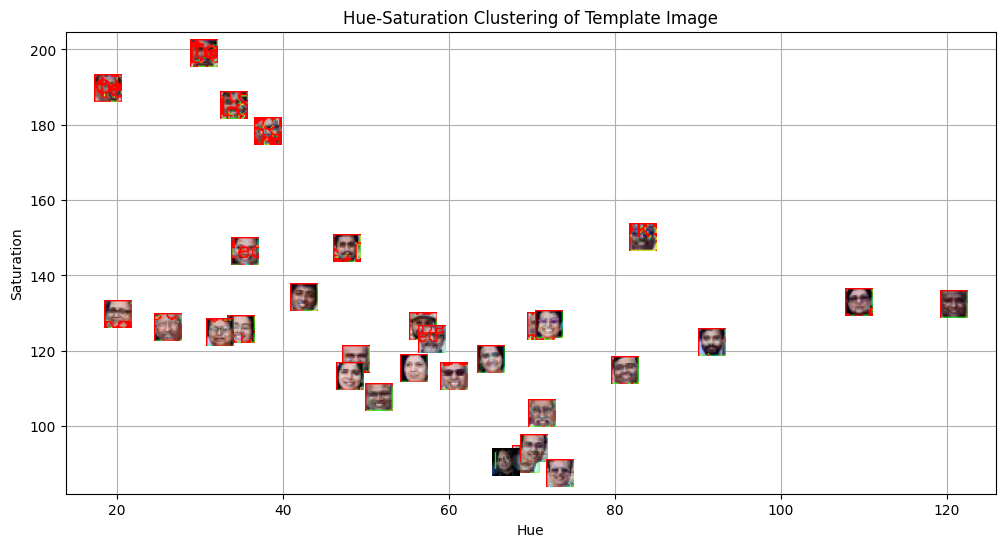

<Figure size 640x480 with 0 Axes>

In [25]:
# Convert the template image to HSV color space and store it in template_hsv
template_hsv = cv2.cvtColor(template_img, cv2.COLOR_BGR2HSV)

# Extract hue and saturation features from the template image as we did it for detected faces.
template_hue = np.mean(template_hsv[:, :, 0])
template_saturation = np.mean(template_hsv[:, :, 1])

# Predict the cluster label for the template image and store it in template_label
template_label = kmeans.predict([[template_hue, template_saturation]])[0]

# Create a figure and axis for visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the clustered faces with custom markers (similar to previous code)
for i, (x, y, w, h) in enumerate(faces_rect):
    color = 'red' if kmeans.labels_[i] == 0 else 'blue'
    im = OffsetImage(cv2.cvtColor(cv2.resize(face_images[i], (20, 20)), cv2.COLOR_HSV2RGB))
    ab = AnnotationBbox(im, (hue_saturation[i, 0], hue_saturation[i, 1]), frameon=False, pad=0)
    ax.add_artist(ab)
    plt.plot(hue_saturation[i, 0], hue_saturation[i, 1], 'o', markersize=5, color=color)

# Plot the template image in the respective cluster
if template_label == 0:
    color = 'red'
else:
    color = 'blue'
im = OffsetImage(cv2.cvtColor(cv2.resize(template_img, (20, 20)), cv2.COLOR_BGR2RGB))
ab = AnnotationBbox(im, (template_hue, template_saturation), frameon=False, pad=0)
ax.add_artist(ab)

plt.xlabel('Hue')
plt.ylabel('Saturation')
plt.title('Hue-Saturation Clustering of Template Image')
plt.grid(True)
plt.show()
wandb.log({"Hue-Saturation Clustering of Template Image": wandb.Image(plt)})

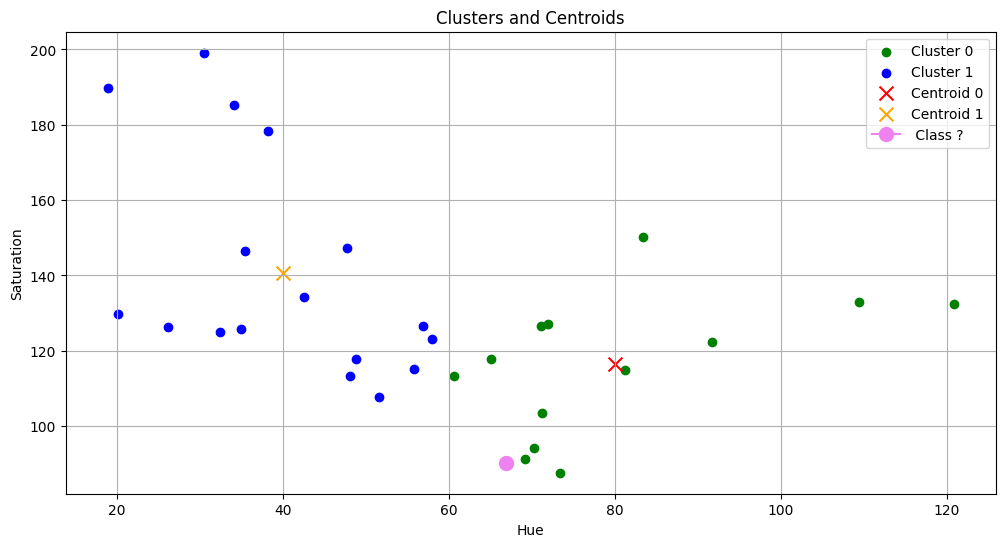

<Figure size 640x480 with 0 Axes>

In [26]:
# Create an empty list to store legend labels
legend_labels = []

# Create lists to store points for each cluster
cluster_0_points = []
cluster_1_points = []

# Your code for scatter plot goes here
fig, ax = plt.subplots(figsize=(12, 6))
for i, (x, y, w, h) in enumerate(faces_rect):
    if kmeans.labels_[i] == 0:
        cluster_0_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))
    else:
        cluster_1_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))

# Plot points for cluster 0 in green
cluster_0_points = np.array(cluster_0_points)
plt.scatter(cluster_0_points[:, 0], cluster_0_points[:, 1], c='green', label='Cluster 0')

# Plot points for cluster 1 in blue
cluster_1_points = np.array(cluster_1_points)
plt.scatter(cluster_1_points[:, 0], cluster_1_points[:, 1], c='blue', label='Cluster 1')

# Calculate and plot centroids for both the clusters
centroid_0 = np.mean(cluster_0_points, axis=0)
centroid_1 = np.mean(cluster_1_points, axis=0)
plt.scatter(centroid_0[0], centroid_0[1], marker='x', c='red', s=100, label='Centroid 0') ## plot for centroid 0
plt.scatter(centroid_1[0], centroid_1[1], marker='x', c='orange', s=100, label='Centroid 1')  ## plot for centroid 1
plt.plot(template_hue, template_saturation, marker='o', c= 'violet',markersize= 10, label=' Class ?' )

plt.xlabel('Hue')  # Put x label
plt.ylabel('Saturation')  # Put y label
plt.title('Clusters and Centroids')  # Put title
plt.legend()  # Add a legend
plt.grid(True)  # Add grid
plt.show()  # Show the plot
wandb.log({"Clusters and Centroids": wandb.Image(plt)})

## Report:
## Answer the following questions within your report:


#### 1. What are the common distance metrics used in distance-based classification algorithms? 
- Euclidean distance, Manhattan distance, Minkowski distance, Hamming distance, Cosine similarity, Jaccard similarity, Mahalanobis distance, etc.

#### 2. What are some real-world applications of distance-based classification algorithms? 
- Examples include image recognition, recommendation systems, and customer segmentation.

#### 3. Explain various distance metrics. 
- Euclidean Distance – it measures the straight line distance between 2 points, commonly used in clustering algorithms.
- Manhattan Distance – it computes the distance by summing absolute differences, its useful when movement is restricted to grid-like paths.
- Mahalanobis Distance – it is for the correlations in data, which makes it effective for detecting anomalies and classifying data with varying distributions.

#### 4. What is the role of cross validation in model performance? 
- Cross-validation is a technique used to evaluate the performance of a model. It involves splitting the dataset into multiple subsets, training the model on some of the subsets, and testing it on the remaining subset. This helps to assess the model's performance on unseen data and avoid overfitting.

#### 5. Explain variance and bias in terms of KNN? 
- Variance refers to the model's sensitivity to training data. A high variance model will change significantly when trained on different subsets of the data. Bias refers to the model's ability to capture the underlying patterns in the data. A high bias model may not be able to capture the complexity of the data. KNN is a high variance, low bias model, as it is sensitive to the training data and does not make strong assumptions about the underlying data distribution.